# COMPAS Recidivism Dataset Bias Analysis

This notebook audits the COMPAS dataset for racial bias using AI Fairness 360.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.metrics import confusion_matrix

# Set style
sns.set(style='whitegrid')

## Data Loading and Preprocessing

Load the COMPAS dataset using AIF360's built-in loader, which replicates the ProPublica preprocessing.

In [17]:
# Load dataset
dataset_orig = CompasDataset()

# Load raw data for decile_score
raw_df = pd.read_csv('compas-scores-two-years.csv')
raw_df = raw_df.dropna(subset=["days_b_screening_arrest"])
raw_df = raw_df[(raw_df.days_b_screening_arrest <= 30) & (raw_df.days_b_screening_arrest >= -30) & (raw_df.is_recid != -1) & (raw_df.c_charge_degree != "O") & (raw_df.score_text != "N/A")]

# Convert to dataframe for easier manipulation
df = dataset_orig.convert_to_dataframe()[0]
df['decile_score'] = raw_df['decile_score'].values[:len(df)]
df.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,...,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,two_year_recid,decile_score
1,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,0.0,24.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
7,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,41.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6


In [18]:
# Define privileged and unprivileged groups
# Privileged: Caucasian (race=1), Unprivileged: African-American (race=0)
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

# Target variable is 'two_year_recid' (recidivated within 2 years)
# Favorable label is 0 (no recidivism), unfavorable is 1
favorable_label = 0
unfavorable_label = 1

## Bias Analysis

Compute fairness metrics: Statistical Parity Difference, Disparate Impact, False Positive Rate, False Negative Rate.

In [19]:
# Compute dataset metrics
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric_orig.statistical_parity_difference())
print("Disparate Impact:", metric_orig.disparate_impact())
print("Mean Difference:", metric_orig.mean_difference())

Statistical Parity Difference: -0.09713793951315464
Disparate Impact: 0.8403836674666473
Mean Difference: -0.09713793951315464


In [20]:
# For classification metrics, we need predicted labels
# In COMPAS, the decile_score is the prediction
# Threshold at 5 for high risk
threshold = 5
dataset_orig_pred = dataset_orig.copy()
dataset_orig_pred.labels = (df['decile_score'] >= threshold).astype(int)

# Classification metrics
classified_metric = ClassificationMetric(dataset_orig, dataset_orig_pred, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

print("False Positive Rate Difference:", classified_metric.false_positive_rate_difference())
print("False Negative Rate Difference:", classified_metric.false_negative_rate_difference())
print("Equal Opportunity Difference:", classified_metric.equal_opportunity_difference())

False Positive Rate Difference: 0.0007040899667791756
False Negative Rate Difference: -0.016012850607921014
Equal Opportunity Difference: 0.016012850607921014


C:\Users\Peter Mwaura\AppData\Local\Programs\Python\Python313\Lib\site-packages\aif360\metrics\utils.py:109: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_pred = y_pred.ravel()


## Visualizations

Create plots for disparities in false positive rates, false negative rates, and recidivism rates by race.

In [21]:
# Prepare data for plotting
df_plot = df.copy()
df_plot['race_label'] = df_plot['race'].map({0: 'African-American', 1: 'Caucasian'})
df_plot['predicted_high_risk'] = (df_plot['decile_score'] >= threshold).astype(int)
df_plot['recidivated'] = df_plot['two_year_recid']

# Confusion matrix by race
cm_aa = confusion_matrix(df_plot[df_plot['race'] == 0]['recidivated'], df_plot[df_plot['race'] == 0]['predicted_high_risk'])
cm_c = confusion_matrix(df_plot[df_plot['race'] == 1]['recidivated'], df_plot[df_plot['race'] == 1]['predicted_high_risk'])

# Calculate rates
tn_aa, fp_aa, fn_aa, tp_aa = cm_aa.ravel()
tn_c, fp_c, fn_c, tp_c = cm_c.ravel()

fpr_aa = fp_aa / (fp_aa + tn_aa)
fpr_c = fp_c / (fp_c + tn_c)
fnr_aa = fn_aa / (fn_aa + tp_aa)
fnr_c = fn_c / (fn_c + tp_c)

print(f"African-American FPR: {fpr_aa:.3f}, Caucasian FPR: {fpr_c:.3f}")
print(f"African-American FNR: {fnr_aa:.3f}, Caucasian FNR: {fnr_c:.3f}")

African-American FPR: 0.425, Caucasian FPR: 0.441
African-American FNR: 0.536, Caucasian FNR: 0.535


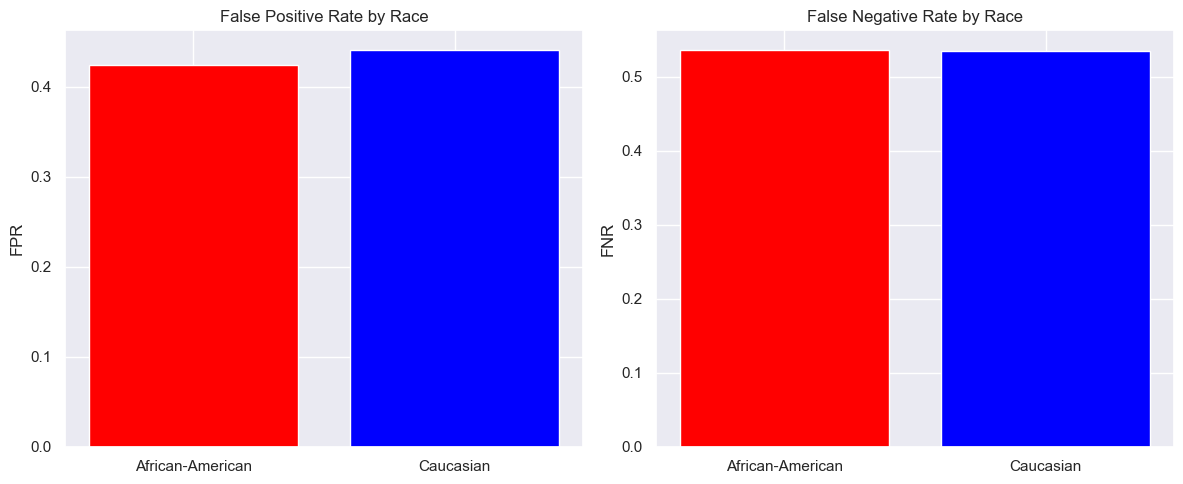

In [22]:
# Plot FPR and FNR disparities
races = ['African-American', 'Caucasian']
fpr_values = [fpr_aa, fpr_c]
fnr_values = [fnr_aa, fnr_c]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(races, fpr_values, color=['red', 'blue'])
ax[0].set_title('False Positive Rate by Race')
ax[0].set_ylabel('FPR')

ax[1].bar(races, fnr_values, color=['red', 'blue'])
ax[1].set_title('False Negative Rate by Race')
ax[1].set_ylabel('FNR')

plt.tight_layout()
plt.show()

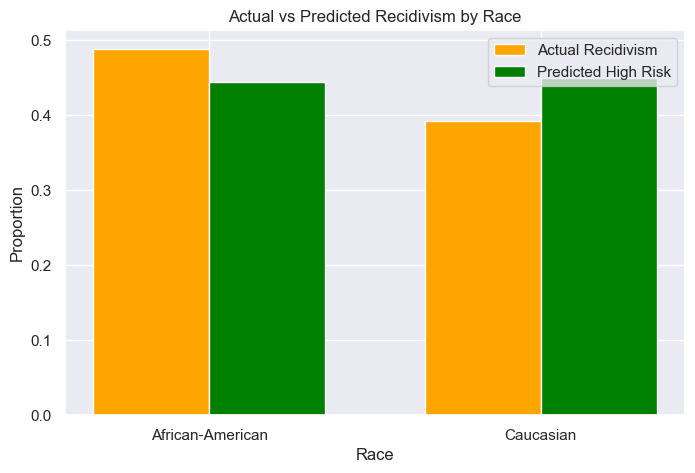

In [23]:
# Plot actual vs predicted recidivism by race
recid_by_race = df_plot.groupby('race_label')['recidivated'].mean()
predicted_by_race = df_plot.groupby('race_label')['predicted_high_risk'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
width = 0.35
x = np.arange(len(races))

ax.bar(x - width/2, recid_by_race.values, width, label='Actual Recidivism', color='orange')
ax.bar(x + width/2, predicted_by_race.values, width, label='Predicted High Risk', color='green')

ax.set_xlabel('Race')
ax.set_ylabel('Proportion')
ax.set_title('Actual vs Predicted Recidivism by Race')
ax.set_xticks(x)
ax.set_xticklabels(races)
ax.legend()

plt.show()

## Bias Mitigation

Apply Reweighing algorithm to mitigate bias.

In [24]:
# Apply Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset_orig)

# Compute metrics after mitigation
metric_transf = BinaryLabelDatasetMetric(dataset_transf, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

print("After Reweighing:")
print("Statistical Parity Difference:", metric_transf.statistical_parity_difference())
print("Disparate Impact:", metric_transf.disparate_impact())
print("Mean Difference:", metric_transf.mean_difference())

After Reweighing:
Statistical Parity Difference: 1.1102230246251565e-16
Disparate Impact: 1.0000000000000002
Mean Difference: 1.1102230246251565e-16


In [25]:
# For classification, apply same threshold
dataset_transf_pred = dataset_transf.copy()
dataset_transf_pred.labels = (df['decile_score'] >= threshold).astype(int)

classified_metric_transf = ClassificationMetric(dataset_transf, dataset_transf_pred, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)

print("False Positive Rate Difference:", classified_metric_transf.false_positive_rate_difference())
print("False Negative Rate Difference:", classified_metric_transf.false_negative_rate_difference())
print("Equal Opportunity Difference:", classified_metric_transf.equal_opportunity_difference())

False Positive Rate Difference: 0.0007040899667793976
False Negative Rate Difference: -0.016012850607921014
Equal Opportunity Difference: 0.016012850607921125


C:\Users\Peter Mwaura\AppData\Local\Programs\Python\Python313\Lib\site-packages\aif360\metrics\utils.py:109: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_pred = y_pred.ravel()
